<a href="https://colab.research.google.com/github/mirfan35/Ridnet/blob/main/ridnet_loss_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
###############################################################################################
# reset device
###############################################################################################
!pip install numba

from numba import cuda
device = cuda.get_current_device()
device.reset()

In [1]:
!pip install tensorflow_io

In [22]:
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers, models
import cv2
import numpy as np
import pickle
import skimage

In [98]:
! pip install -U --no-cache-dir gdown --pre
import gdown
gdown.download(id='199xKPSJOOApvE3q-9zDTvTn_F7SsklP8', output='dataset.pckl')

Downloading...
From (uriginal): https://drive.google.com/uc?id=199xKPSJOOApvE3q-9zDTvTn_F7SsklP8
From (redirected): https://drive.google.com/uc?id=199xKPSJOOApvE3q-9zDTvTn_F7SsklP8&confirm=t&uuid=723884c4-e48c-4de6-8bf6-50f9ccdb3990
To: /content/dataset.pckl
100%|██████████| 258M/258M [00:09<00:00, 26.5MB/s]


'dataset.pckl'

In [3]:
###############################################################################################
# allocate GPU vram for tensorflow
###############################################################################################
import torch
torch.cuda.empty_cache()

#Setting gpu for limit memory
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    #Restrict Tensorflow to only allocate 11.7gb of memory (vram) on the first GPU
   try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=15000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
   except RuntimeError as e:
       #virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [99]:
###############################################################################################
# load image
###############################################################################################
f = open(r'dataset.pckl', 'rb')
data_in, data_out = pickle.load(f)
f.close()

In [100]:
###############################################################################################
# normalize
###############################################################################################
x_train = np.float32(data_in)/255
y_train = np.float32(data_out)/255

## random shuffle traning data (optional) ##
seed = np.random.randint(123)
np.random.seed(seed)
np.random.shuffle(x_train)
np.random.seed(seed)
np.random.shuffle(y_train)

## shorten training data (optional) ##
# arr_len = int(len(x_train)*1/3)
# x_train = x_train[:arr_len]
# y_train = y_train[:arr_len]

In [6]:
###############################################################################################
# Enhancement Attention Modules (EAM)
###############################################################################################
def EAM(input):
	conv1 = layers.Conv2D(64, (3,3), dilation_rate=1,padding='same',activation='relu')(input)
	conv1 = layers.Conv2D(64, (3,3), dilation_rate=2,padding='same',activation='relu')(conv1)

	conv2 = layers.Conv2D(64, (3,3), dilation_rate=3,padding='same',activation='relu')(input)
	conv2 = layers.Conv2D(64, (3,3), dilation_rate=4,padding='same',activation='relu')(conv2)

	concat = layers.concatenate([conv1,conv2])
	conv3 = layers.Conv2D(64, (3,3),padding='same',activation='relu')(concat)
	add1 = layers.Add()([input,conv3])

	conv4 = layers.Conv2D(64, (3,3),padding='same',activation='relu')(add1)
	conv4 = layers.Conv2D(64, (3,3),padding='same')(conv4)
	add2 = layers.Add()([conv4,add1])
	add2 = layers.Activation('relu')(add2)

	conv5 = layers.Conv2D(64, (3,3),padding='same',activation='relu')(add2)
	conv5 = layers.Conv2D(64, (3,3),padding='same',activation='relu')(conv5)
	conv5 = layers.Conv2D(64, (1,1),padding='same')(conv5)
	add3 = layers.Add()([add2,conv5])
	add3 = layers.Activation('relu')(add3)

	gap = layers.GlobalAveragePooling2D()(add3)
	gap = layers.Reshape((1,1,64))(gap)
	conv6 = layers.Conv2D(64, (3,3),padding='same',activation='relu')(gap)
	conv6 = layers.Conv2D(64, (3,3),padding='same',activation='sigmoid')(conv6)

	mul = layers.Multiply()([conv6, add3])
	out = layers.Add()([input,mul]) # This is not included in the reference code
	return out

In [101]:
###############################################################################################
# RIDnet autoencoder (https://medium.com/analytics-vidhya/image-denoising-using-deep-learning-dc2b19a3fd54)
###############################################################################################
#### RIDnet layers ####
tf.keras.backend.clear_session()
input = keras.Input(shape=(64, 64, 3))
conv1 = layers.Conv2D(64 , (3,3),padding='same')(input)
eam1 = EAM(conv1)
eam2 = EAM(eam1)
eam3 = EAM(eam2)
eam4 = EAM(eam3)
conv2 = layers.Conv2D(3, (3,3),padding='same')(eam4)
output = layers.Add()([input,conv2])
#### RIDnet layers ####

RIDNet = keras.Model(input,output)

In [8]:
##################################################################################
# mssim from cv2 (https://docs.opencv.org/4.x/d5/dc4/tutorial_video_input_psnr_ssim.html)
##################################################################################
def MSSIM(I1, I2, win=11):
    C1 = 6.5025
    C2 = 58.5225

    # PRELIMINARY COMPUTING
    mu1 = tfio.experimental.filter.gaussian(I1, ksize=[win, win], sigma=1.5, mode='REFLECT') #mean
    mu2 = tfio.experimental.filter.gaussian(I2, ksize=[win, win], sigma=1.5, mode='REFLECT')
    mu1_2 = mu1**2
    mu2_2 = mu2**2
    mu1_mu2 = mu1*mu2
    sigma1_2 = tfio.experimental.filter.gaussian(I1**2, ksize=[win, win], sigma=1.5, mode='REFLECT') - mu1_2 # variance (shortcut formula)
    sigma2_2 = tfio.experimental.filter.gaussian(I2**2, ksize=[win, win], sigma=1.5, mode='REFLECT') - mu2_2
    sigma12 = tfio.experimental.filter.gaussian(I1*I2, ksize=[win, win], sigma=1.5, mode='REFLECT') - mu1_mu2 # covariance (shortcut formula)

    t1 = 2 * mu1_mu2 + C1
    t2 = 2 * sigma12 + C2
    t3 = t1 * t2                    # t3 = ((2*mu1_mu2 + C1).*(2*sigma12 + C2))
    t1 = mu1_2 + mu2_2 + C1
    t2 = sigma1_2 + sigma2_2 + C2
    t1 = t1 * t2                    # t1 =((mu1_2 + mu2_2 + C1).*(sigma1_2 + sigma2_2 + C2))

    ssim_map = t3/t1    # ssim_map =  t3./t1;

    mssim = tf.reduce_mean(ssim_map)       # mssim = average of ssim map

    return mssim

In [9]:
##################################################################################
# absolute mssim
##################################################################################
def absoluteMSSIM(I1, I2, win=11):
    C3 = 23
    k = 27

    # PRELIMINARY COMPUTING
    mu1 = tfio.experimental.filter.gaussian(I1, ksize=[win, win], sigma=1.5, mode='REFLECT') #mean
    mu2 = tfio.experimental.filter.gaussian(I2, ksize=[win, win], sigma=1.5, mode='REFLECT')
    sigma1_2 = tfio.experimental.filter.gaussian(I1**2, ksize=[win, win], sigma=1.5, mode='REFLECT') - mu1**2 # variance (shortcut formula)
    sigma2_2 = tfio.experimental.filter.gaussian(I2**2, ksize=[win, win], sigma=1.5, mode='REFLECT') - mu2**2

    sigma12 = tfio.experimental.filter.gaussian(I1*I2, ksize=[win, win], sigma=1.5, mode='REFLECT') - mu1*mu2 # covariance (shortcut formula)

    sigma1 = tf.sqrt(tf.maximum(sigma1_2, 1e-9)) # prevent nan value
    sigma2 = tf.sqrt(tf.maximum(sigma2_2, 1e-9)) # prevent nan value

    lm = 1 - tf.math.abs(mu1 - mu2)/255 # luminance
    cn = MinMaxRatio(sigma1, sigma2, thr=k) # contrast
    st = tf.maximum((sigma12+C3)/((sigma1*sigma2)+C3), 0) # structure

    ssim_map = lm*cn*st
    mssim = tf.reduce_mean(ssim_map)

    return mssim

##################################################################################
# ratio of between small to large (a/b if a<b)
##################################################################################
def MinMaxRatio(a,b,thr=0):
	tot = a+b
	dif = tf.math.abs(a-b)
	return (tot-dif+2*thr)/(tot+dif+2*thr)

In [103]:
###############################################################################################
# loss function (ssim and absolute ssim)
###############################################################################################
def ssim_loss(y_true, y_pred):
    return 1 - MSSIM(y_true*255, y_pred*255)

def assim_loss(y_true, y_pred):
    return 1 - absoluteMSSIM(y_true*255, y_pred*255)

def tf_ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

RIDNet.compile(optimizer=tf.keras.optimizers.Adam(1e-03), loss=tf.keras.losses.MeanSquaredError())
# RIDNet.compile(optimizer=tf.keras.optimizers.Adam(1e-03), loss=assim_loss, run_eagerly=True)

In [ ]:
###############################################################################################
# Training
###############################################################################################
torch.cuda.empty_cache()

# print(RIDNet.summary())
model_name = 'RIDNet64(mse).h5'
check_point = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss')
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5)
RIDNet.fit(x_train, y_train, epochs=30, validation_split=0.1, batch_size=16, callbacks=[check_point, early_stopping])

RIDNet.compile(optimizer=tf.keras.optimizers.Adam(1e-03), loss=tf.keras.losses.MeanSquaredError()) # replace loss function after training
RIDNet.save(model_name)

print('done')

Epoch 1/30
591/591 [==============================] - ETA: 0s - loss: 0.0266

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


591/591 [==============================] - 134s 195ms/step - loss: 0.0266 - val_loss: 8.7633e-04
Epoch 2/30
591/591 [==============================] - 116s 197ms/step - loss: 7.8989e-04 - val_loss: 7.4866e-04
Epoch 3/30
591/591 [==============================] - 116s 197ms/step - loss: 6.6405e-04 - val_loss: 5.9799e-04
Epoch 4/30
591/591 [==============================] - 117s 199ms/step - loss: 6.0481e-04 - val_loss: 6.0318e-04
Epoch 5/30
591/591 [==============================] - 117s 199ms/step - loss: 5.5345e-04 - val_loss: 5.1253e-04
Epoch 6/30
591/591 [==============================] - 117s 199ms/step - loss: 5.1969e-04 - val_loss: 5.0760e-04
Epoch 7/30
591/591 [==============================] - 118s 199ms/step - loss: 5.0496e-04 - val_loss: 5.2245e-04
Epoch 8/30
591/591 [==============================] - 116s 197ms/step - loss: 4.8332e-04 - val_loss: 4.8491e-04
Epoch 9/30
591/591 [==============================] - 116s 197ms/step - loss: 4.7255e-04 - val_loss: 4.7406e-04
Epoch 1

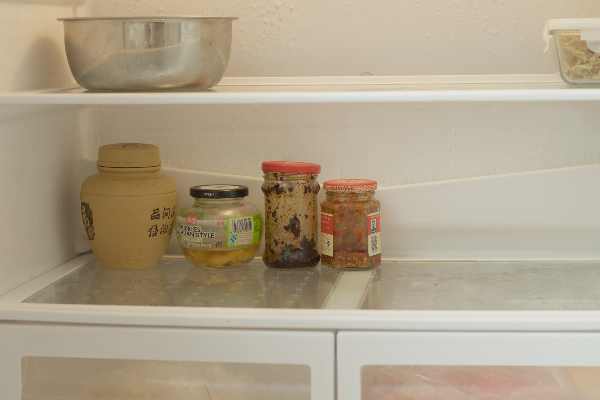

In [16]:
img = cv2.imread('120.png')

from google.colab.patches import cv2_imshow
cv2_imshow(img)

In [93]:
###############################################################################################
# even split and merge
###############################################################################################
def evenLengthSeperation(l, s=64): ## find seperation tiles for certain length
	tot = l//s + 1 if l%s!=0 else l//s # total windows
	rem = (tot*s)-l

	a_ovl = rem//(tot-1) # average overlay
	f_ovl = a_ovl + rem%(tot-1) # final overlay

	## first tile ##
	tiles_ind = []
	st = 0
	low = st
	high = st+s
	tiles_ind.append([low, high])

	## in-between tiles ##
	for x in range(0,tot-2):
		st = high-a_ovl
		low = st
		high = st+s
		tiles_ind.append([low, high])
		pass

	## last tile ##
	st = high-f_ovl
	low = st
	high = st+s
	tiles_ind.append([low, high])

	return tiles_ind

def image2Tiles(img, tile_size=64):
	h, w = img.shape[0], img.shape[1]

	# find tiles index
	y_tiles = np.array(evenLengthSeperation(h, tile_size))
	x_tiles = np.array(evenLengthSeperation(w, tile_size))

	res = [img[y_l:y_h, x_l:x_h] for y_l, y_h in y_tiles for x_l, x_h in x_tiles]

	return np.array(res, dtype=np.uint8), [y_tiles, x_tiles]

def tiles2image(tiles, met):
	y_tiles, x_tiles = met
	h = np.max(y_tiles[:,1])
	w = np.max(x_tiles[:,1])

	if len(np.shape(tiles))>3:
		res = np.zeros((h,w,tiles.shape[3]), dtype=np.float32)
		tot = np.zeros((h,w,tiles.shape[3]), dtype=np.float32)
	else:
		res = np.zeros((h,w), dtype=np.float32)
		tot = np.zeros((h,w), dtype=np.float32)
		pass

	ii = 0
	for y_l, y_h in y_tiles:
		for x_l, x_h in x_tiles:
			res[y_l:y_h, x_l:x_h] += tiles[ii]
			tot[y_l:y_h, x_l:x_h] += 1
			ii+=1
			pass

	res /= tot
	return res

In [33]:
###############################################################################################
# fastest ways to convert float image to round uint8
###############################################################################################
def ruint8(arr):
	return np.uint8(arr+0.5)

###############################################################################################
# fastest ways clip an array
###############################################################################################
def clip(arr, a_min, a_max):
	return np.core.umath.maximum(np.core.umath.minimum(arr, a_max), a_min)

In [92]:
###############################################################################################
# autoencoder test
###############################################################################################
def AutoenDenoiser(img, autoencoder, win_size=64):
  tiles, met = image2Tiles(img, win_size)

  tiles = np.squeeze(autoencoder.predict([np.float32(tiles)/255], verbose=0))

  return ruint8(clip(tiles2image(tiles, met),0,1)*255)

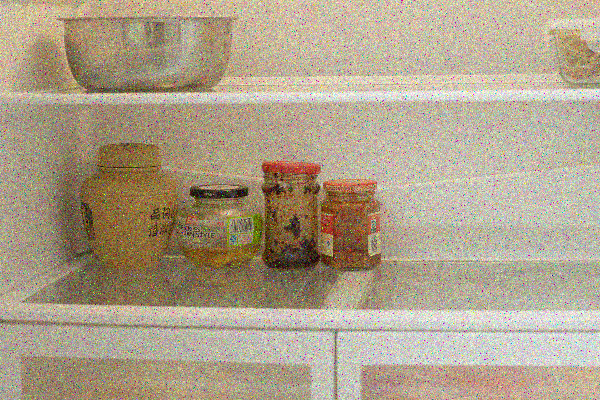

In [82]:
###############################################################################################
# test ridnet
###############################################################################################
nimg = addNoise(img, 0.01, 0.01)
cv2_imshow(nimg)

In [95]:
autoencoder = models.load_model(r'RIDNet256(msr).h5', custom_objects={"EAM": EAM}, compile=False)

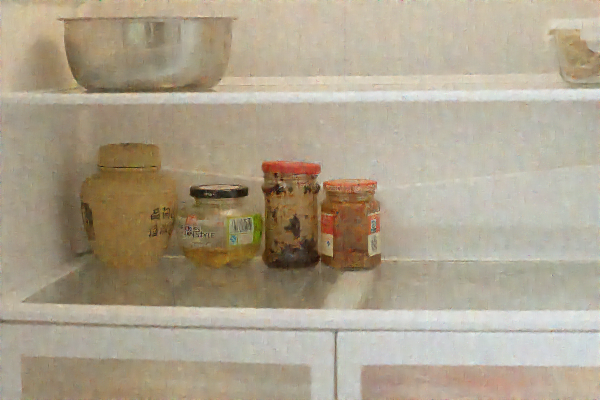

In [96]:
res = AutoenDenoiser(nimg, autoencoder, win_size=256)
cv2_imshow(res)